In [1]:
import os
import json
from os.path import join, dirname, expanduser, splitext, basename
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import leafmap.leafmap as leafmap
from dotenv import load_dotenv
import xarray as xr
import rioxarray as rxr
from PIL import Image
from shapely.geometry import mapping, Polygon
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
# import delayed from dask
import dask

load_dotenv()

False

## dont change anything here 

In [ ]:
# /home/patel_zeel/kiln_compass_24/data/lucknow_airshed/metadata.geojson
# /home/patel_zeel/kiln_compass_24/data/delhi_airshed/metadata.geojson

state_label="dhaka"
state="dhaka_grid_train"
save_region="dhaka_grid_train_patch"

base_path="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns"
# base_path="/home/patel_zeel/kiln_compass_24"

mosaic_id="global_quarterly_2024q1_mosaic"
image_meta_data=f"{base_path}/raw_data/metadata/{state}/{mosaic_id}/metadata.geojson"

imagery_dir = f"{base_path}/raw_data/imagery/{mosaic_id}"

state_label_path=f"../after_hand_validation_data/bangladesh_v2/final_data/{state_label}.geojson"
stete_shape_path=f"{base_path}/regions/shapes/{state}.geojson"
save_dir=f"../data/processed_data/{save_region}/"
os.makedirs(save_dir, exist_ok=True)

print(f"state: {state}")
print(f"base_path: {base_path}")
print(f"mosaic_id: {mosaic_id}")
print(f"image_meta_data: {image_meta_data}")
print(f"imagery_dir: {imagery_dir}")
# print(f"state_label_path: {state_label_path}")
print(f"stete_shape_path: {stete_shape_path}")
print(f"save_dir: {save_dir}")


state: dhaka_grid_train
base_path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns
mosaic_id: global_quarterly_2024q1_mosaic
image_meta_data: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/metadata/dhaka_grid_train/global_quarterly_2024q1_mosaic/metadata.geojson
imagery_dir: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/raw_data/imagery/global_quarterly_2024q1_mosaic
stete_shape_path: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/dhaka_grid_train.geojson
save_dir: ../data/processed_data/dhaka_train_grid_patch/


In [ ]:
gdf_labels = gpd.read_file(state_label_path).drop("style", errors="ignore", axis=1)
print(gdf_labels.head())
color_mapping = {"CFCBK": "red", "FCBK": "orange", "Zigzag": "green"}
gdf_labels["style"] = gdf_labels["class_name"].apply(lambda x: {"color": color_mapping[x]})
print(gdf_labels.head())
gdf_images = gpd.read_file(image_meta_data)
print(gdf_images.head())
# print(len(gdf_labels), len(gdf_images))
gdf_image_paths = [join(f"{base_path}/raw_data/imagery/global_quarterly_2024q1_mosaic", f"{Id}.tif") for Id in gdf_images["id"]]
print(len(gdf_image_paths))
# print(gdf_image_paths[:5])



  class_name  confidence    max_lon    min_lon    max_lat    min_lat  \
0     Zigzag    0.859019  90.316177  90.314750  23.762170  23.761552   
1     Zigzag    0.446674  90.065491  90.064851  23.770524  23.769443   
2     Zigzag    0.487422  90.319510  90.318356  23.777604  23.776997   
3     Zigzag    0.417033  90.899404  90.898330  24.323877  24.323350   
4     Zigzag    0.563883  90.318835  90.317803  23.777553  23.777006   

   center_lat  center_lon  width_of_box  height_of_box  ...         area  \
0   23.761861   90.315464    145.465378      68.446462  ...  9416.696111   
1   23.769983   90.065171     65.236088     119.726057  ...  6891.104513   
2   23.777300   90.318933    117.622455      67.228294  ...  6379.767999   
3   24.323614   90.898867    109.006170      58.372057  ...  5928.414779   
4   23.777279   90.318319    105.187540      60.582993  ...  5879.550321   

                                                  id           x          y  \
0  5f5bb2e5f4b4b4f915ee863c8059

# images processing

In [14]:
m=leafmap.Map()
m.add_basemap("HYBRID")
m.add_geojson(image_meta_data,zoom_to_layer=True)
m

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [15]:
size_in_gb = sum([os.path.getsize(fp)/1024/1024/1024 for fp in gdf_image_paths])
print(f"Total size of images: {size_in_gb:.2f} GB")

Total size of images: 0.94 GB


In [2]:
# Path to planet quads 4096x4096
from glob import glob
# gdf_image_paths = glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/raw_data/lucknow_data_imagery/global_quarterly_2024q1_mosaic/*')
# gdf_image_paths = glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/raw_data/wb_small_airshed_imagery/global_quarterly_2024q1_mosaic/*')
gdf_image_paths = glob('/home/shataxi.dubey/shataxi_work/vlm_on_planet/raw_data/ahmedabad_10km_buffer_imagery/global_quarterly_2024q1_mosaic/*')

In [3]:
# verifying number of quads along x and y axis
print(len(gdf_image_paths))
x = np.unique(np.concatenate([xr.open_dataset(path).x.values for path in gdf_image_paths]))
x.sort()
xdiff_index = pd.Series(x).diff().value_counts().index
print(xdiff_index)
print(x)
print(len(x),len(x)/4096)
print(len(gdf_image_paths))
y = np.unique(np.concatenate([xr.open_dataset(path).y.values for path in gdf_image_paths]))
y.sort()
diff_index = pd.Series(y).diff().value_counts().index
print(diff_index)
print(len(y), len(y)/4096)

9
Index([4.777314267121255, 4.777314268052578, 4.7773139998316765], dtype='float64')
[8042400.755599   8042405.53291327 8042410.31022753 ... 8120657.94060947
 8120662.71792373 8120667.495238  ]
16384 4.0
9
Index([4.777314267121255, 4.777314267586917, 4.777314000297338,
       4.7773139998316765],
      dtype='float64')
12288 3.0


In [4]:
# import xarray as xr

# # Load one file to inspect its `y` values
# ds = xr.open_dataset(gdf_image_paths[0])  # Replace with an actual path if needed
# print(ds.y.values)
# ds = xr.open_dataset(gdf_image_paths[0])  # Replace with a single file
# if not (ds.y.values[0] < ds.y.values[-1]):  # Check if `y` is not increasing
#     ds = ds.sortby('y')  # Sort by the `y` dimension
# print(ds.y.values)
# sorted_datasets = []
# for path in gdf_image_paths:
#     ds = xr.open_dataset(path)
#     if not (ds.y.values[0] < ds.y.values[-1]):  # Check if `y` is not increasing
#         ds = ds.sortby('y')
#     sorted_datasets.append(ds)



In [5]:
# for path in gdf_image_paths:
#     ds = xr.open_dataset(path)
#     if not (ds.y.values[0] < ds.y.values[-1]):  # Check and sort
#         ds = ds.sortby('y')
#     ds.to_netcdf(path)  # Overwrite the file with sorted dimensions


In [6]:
# combined_ds = xr.combine_by_coords(sorted_datasets)
# print(combined_ds)


In [7]:
ds=xr.open_mfdataset(gdf_image_paths)
print(ds)
assert len(ds.x.values) % 4096 == 0
assert len(ds.y.values) % 4096 == 0

<xarray.Dataset>
Dimensions:      (band: 4, x: 16384, y: 12288)
Coordinates:
  * band         (band) int64 1 2 3 4
  * x            (x) float64 8.042e+06 8.042e+06 ... 8.121e+06 8.121e+06
  * y            (y) float64 2.661e+06 2.661e+06 ... 2.603e+06 2.603e+06
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>


##### only change this cell as needed

In [8]:
#defining the image size and overlap
# defining the list of centers of the images

image_size=320
overlap=64
gap_between_centers=image_size-overlap
x_centers=[image_size//2]
x_centers.extend(list(range(x_centers[0]+gap_between_centers, len(ds.x)-x_centers[0], gap_between_centers)))
x_centers=x_centers[:-1]
y_centers=[image_size//2]
y_centers.extend(list(range(y_centers[0]+gap_between_centers, len(ds.y)-y_centers[0], gap_between_centers)))
y_centers=y_centers[:-1]
print(len(x_centers), len(y_centers))

62 46


In [9]:
# defining the boundaries/geometries of the image

x_values=ds.x.values
y_values=ds.y.values

def get_geometry(x_idx,y_idx):
    start_x=x_values[x_idx-image_size//2] #left boundary
    start_y=y_values[y_idx-image_size//2] #buttom boundary
    end_x=x_values[x_idx+image_size//2] #right boundary
    end_y=y_values[y_idx+image_size//2] #top boundary
    return Polygon([(start_x,start_y),(end_x,start_y),(end_x,end_y),(start_x,end_y)])

print(get_geometry(x_centers[0],y_centers[0]))

X,Y=np.meshgrid(x_centers,y_centers)
geometries=[get_geometry(x,y) for x,y in tqdm(zip(X.ravel(),Y.ravel()))]
x_indices=[x for x in X.ravel()]
y_indices=[y for y in Y.ravel()]
print(len(geometries),len(x_indices),len(y_indices))


POLYGON ((8042400.755599 2661229.187756, 8043929.496164568 2661229.187756, 8043929.496164568 2659700.4471905106, 8042400.755599 2659700.4471905106, 8042400.755599 2661229.187756))


0it [00:00, ?it/s]

2852 2852 2852


In [10]:
# indices of the centres of the images
x_indices
y_indices

[160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 160,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 416,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672,
 672

In [11]:
# creating geodataframe from the geometries of the image
potential_image_gdf=gpd.GeoDataFrame(geometry=geometries)
print(len(potential_image_gdf))
potential_image_gdf["x_idx"]=x_indices
potential_image_gdf["y_idx"]=y_indices
potential_image_gdf.reset_index(inplace=True,drop=True)
print(ds.rio.crs)   
potential_image_gdf.crs=ds.rio.crs
print("number of potential images: ",len(potential_image_gdf))
potential_image_gdf.head(2)


2852
EPSG:3857
number of potential images:  2852


geometry  x_idx  y_idx
0  POLYGON ((8042400.756 2661229.188, 8043929.496...    160    160
1  POLYGON ((8043623.748 2661229.188, 8045152.489...    416    160

In [12]:
# finding all the images that are lying inside the shape file
# state_shape_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/lucknow_airshed.geojson'
# state_shape_path = '/home/patel_zeel/kiln_compass_24/raw_shapefiles/wb_small_airshed.geojson'
state_shape_path = '/home/patel_zeel/kiln_compass_24/raw_shapefiles/ahmedabad.geojson'
shape_gdf=gpd.read_file(state_shape_path)
print(shape_gdf.crs)
shape_gdf=shape_gdf.to_crs("EPSG:3857")
assert potential_image_gdf.crs == shape_gdf.crs
print(shape_gdf.crs)
images_within_shape = gpd.sjoin(shape_gdf, potential_image_gdf, predicate="contains")
images_within_shape = potential_image_gdf.loc[images_within_shape.index_right]
display(images_within_shape.head(2))
len(images_within_shape)

EPSG:4326
EPSG:3857


geometry  x_idx  y_idx
1833  POLYGON ((8085205.491 2625762.407, 8086734.232...   9120   7584
1772  POLYGON ((8086428.484 2626985.399, 8087957.224...   9376   7328

58

In [13]:
#save the grid of potential images within the state boundary as a kml file for visualization
# images_within_shape.to_file(f"{save_dir}/potential_images_within_state_boundary.kml",driver="KML")


In [14]:
# m = leafmap.Map()
# m.add_basemap("HYBRID")
# m.add_gdf(shape_gdf, layer_name="Shape", style={"color": "black"})
# m.add_gdf(images_within_shape, layer_name="Images within shape",zoom_to_layer=True)
# m

In [15]:
# getting the centres in webm format from centre indices
images_within_shape['x'] = images_within_shape['x_idx'].apply(lambda x: int(x_values[x]))
images_within_shape['y'] = images_within_shape['y_idx'].apply(lambda x: int(y_values[x]))
images_within_shape.head(6)

geometry  x_idx  y_idx  \
1833  POLYGON ((8085205.491 2625762.407, 8086734.232...   9120   7584   
1772  POLYGON ((8086428.484 2626985.399, 8087957.224...   9376   7328   
1834  POLYGON ((8086428.484 2625762.407, 8087957.224...   9376   7584   
1647  POLYGON ((8085205.491 2629431.384, 8086734.232...   9120   6816   
1586  POLYGON ((8086428.484 2630654.376, 8087957.224...   9376   6560   
1888  POLYGON ((8076644.544 2624539.414, 8078173.285...   7328   7840   

            x        y  
1833  8085969  2624998  
1772  8087192  2626221  
1834  8087192  2624998  
1647  8085969  2628667  
1586  8087192  2629890  
1888  8077408  2623775

In [16]:
save_region = 'ahmedabad_10km_buffer'

In [17]:
os.makedirs(f"./data/processed_data/{save_region}", exist_ok=True)
images_within_shape.reset_index(drop=True).to_file(f"./data/processed_data/{save_region}/metadata.geojson", driver="GeoJSON")

In [18]:
save_dir = f'./data/processed_data/{save_region}'

In [19]:
# selecting the webm of the images from the quads and saving the image with name as webm of the centres of image
samples = []
x_idx_list = []
y_idx_list = []
for x_idx, y_idx in tqdm(zip(images_within_shape["x_idx"], images_within_shape["y_idx"])):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    if os.path.exists(save_path):
        try:
            image = Image.open(save_path)
            assert image.size == (image_size, image_size)
            continue
        except Exception as e:
            print(f"Error: {e}")
            print(f"Loading {save_path} failed. Overwriting the file.")
    sample = ds.isel(x=slice(x_idx - image_size//2, x_idx + image_size//2), y=slice(y_idx - image_size//2, y_idx + image_size//2), band=slice(0, 3))
    samples.append(sample)
    x_idx_list.append(x_idx)
    y_idx_list.append(y_idx)

0it [00:00, ?it/s]

In [20]:
print(len(samples), len(x_idx_list), len(y_idx_list))

58 58 58


In [21]:
# saving the file and laoding the band information
def save_sample(sample, x_idx, y_idx):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    
    sample = sample.band_data.load()
    # fill NaN values with 0
    sample = sample.fillna(0)
    # convert to uint8
    sample = sample.astype(np.uint8)
    sample.rio.to_raster(save_path)
    del sample

In [22]:
delayed_tasks = [dask.delayed(save_sample)(sample, x_idx, y_idx) for sample, x_idx, y_idx in tqdm(zip(samples, x_idx_list, y_idx_list))]
print("Number of delayed tasks:", len(delayed_tasks))

0it [00:00, ?it/s]

Number of delayed tasks: 58


In [23]:
os.makedirs(join(save_dir, "images"), exist_ok=True)
for i in tqdm(range(0, len(delayed_tasks), 1000)):
    _ = dask.compute(*delayed_tasks[i:i+1000])

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
from PIL import Image
img = Image.open('/home/shataxi.dubey/shataxi_work/vlm_on_planet/data/processed_data/ahmedabad_10km_buffer/images/8068847_2629890.tif')
img

# Labels Processing

In [25]:
# state_label_path = '/home/patel_zeel/kiln_compass_24/regions/labels/lucknow_airshed.geojson'
# state_label_path = '/home/patel_zeel/kiln_compass_24/regions/labels/wb_small_airshed.geojson'
state_label_path = '/home/patel_zeel/kiln_compass_24/regions/labels/ahmedabad_10km_buffer.geojson'
gdf_labels = gpd.read_file(state_label_path).drop("style", errors="ignore", axis=1)

In [26]:
## Load the state geojson
gdf_labels_webm=gdf_labels.to_crs(potential_image_gdf.crs)
gdf_labels_webm.reset_index(inplace=True, drop=True)
print(gdf_labels_webm.crs)
print("Number of labels:", len(gdf_labels_webm))

gdf_labels_webm.head(2)

PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]
Number of labels: 147


class_name  confidence    max_lon    min_lon    max_lat    min_lat  \
0       FCBK         1.0  72.425637  72.424469  23.003061  23.002277   
1       FCBK         1.0  72.750525  72.749351  22.947627  22.946987   

   center_lat  center_lon  width_of_box  height_of_box  ...  epsg  \
0   23.002669   72.425053    119.739518      86.860460  ...  3857   
1   22.947307   72.749938    120.482216      70.809413  ...  3857   

   image_width  image_height image_center_x  image_center_y  zoom  resolution  \
0         1120          1120          23.00           72.42    17         NaN   
1         1120          1120          22.95           72.75    17         NaN   

   source  task_name                                           geometry  
0  Manual             POLYGON ((8062385.030 2632337.404, 8062364.662...  
1  Manual             POLYGON ((8098551.448 2625630.433, 8098541.512...  

[2 rows x 24 columns]

In [27]:
# finding all the images which has a label file associated with them
images_with_label=gpd.sjoin(images_within_shape,gdf_labels_webm,predicate="contains")
images_with_label['geometry_right'] = images_with_label['index_right'].apply(lambda x: gdf_labels_webm.loc[x, 'geometry'])
print(f"Number of labels to write: {len(images_with_label)}")

print(f"Number of unique images: {len(images_with_label.drop_duplicates(subset='geometry'))}")
print(f"Number of unique labels: {len(images_with_label.drop_duplicates(subset='geometry_right'))}")

Number of labels to write: 2
Number of unique images: 1
Number of unique labels: 2


In [28]:
# images_within_shape
# gdf_labels_webm

In [29]:
class_mapping = {"CFCBK": 0, "FCBK": 1, "Zigzag": 2}

def get_yolo_label(x):
    min_x, min_y, max_x, max_y = x['geometry'].bounds
    coords = np.array(x['geometry_right'].__geo_interface__['coordinates'][0])
    coords = coords[:-1]
    # normalize
    coords[:, 0] = (coords[:, 0] - min_x) / (max_x - min_x)
    coords[:, 1] = 1 - (coords[:, 1] - min_y) / (max_y - min_y)
    
    coords = coords.ravel()
    assert len(coords) == 8
    
    class_id = class_mapping[x['class_name']]
    label = np.zeros(9) * np.nan
    label[0] = class_id
    label[1:] = coords
    return label



In [30]:
images_with_label['yolo_label'] = images_with_label.apply(get_yolo_label, axis=1)
images_with_label.head(2)
ready_to_save_gdf = images_with_label.groupby("geometry").agg({"yolo_label": np.vstack, "x_idx": "first", "y_idx": "first"}).reset_index()
len(ready_to_save_gdf)

1

In [31]:
ready_to_save_gdf['x'] = ready_to_save_gdf['x_idx'].apply(lambda x: str(int(x_values[x])))
ready_to_save_gdf['y'] = ready_to_save_gdf['y_idx'].apply(lambda x: str(int(y_values[x])))
len(ready_to_save_gdf)
display(ready_to_save_gdf.tail(2))

geometry  \
0  POLYGON ((8071752.574 2624539.414, 8073281.315...   

                                          yolo_label  x_idx  y_idx        x  \
0  [[1.0, 0.3333495208190822, 0.8249150123301385,...   6304   7840  8072516   

         y  
0  2623775

In [32]:
# obtaining all images whose label file exists or that contains kilns
samples = []
x_idx_list = []
y_idx_list = []
for x_idx, y_idx in tqdm(zip(ready_to_save_gdf["x_idx"], ready_to_save_gdf["y_idx"])):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    if os.path.exists(save_path):
        try:
            image = Image.open(save_path)
            assert image.size == (image_size, image_size)
            continue
        except Exception as e:
            print(f"Error: {e}")
            print(f"Loading {save_path} failed. Overwriting the file.")
    sample = ds.isel(x=slice(x_idx - image_size//2, x_idx + image_size//2), y=slice(y_idx - image_size//2, y_idx + image_size//2), band=slice(0, 3))
    samples.append(sample)
    x_idx_list.append(x_idx)
    y_idx_list.append(y_idx)

0it [00:00, ?it/s]

In [33]:
# obtaining all images whose label file exists
len(samples), len(x_idx_list), len(y_idx_list)

(0, 0, 0)

In [34]:
save_dir

'./data/processed_data/ahmedabad_10km_buffer'

In [35]:
# preparing all images whose label file exists or contains kilns for saving in raster format(tif format)
# preparing the task of saving images
delayed_tasks = [dask.delayed(save_sample)(sample, x_idx, y_idx) for sample, x_idx, y_idx in tqdm(zip(samples, x_idx_list, y_idx_list))]
print("Number of delayed tasks:", len(delayed_tasks))

0it [00:00, ?it/s]

Number of delayed tasks: 0


In [36]:
# saving all images containing kilns 
os.makedirs(join(save_dir, "images"), exist_ok=True)
for i in tqdm(range(0, len(delayed_tasks), 1000)):
    _ = dask.compute(*delayed_tasks[i:i+1000])

0it [00:00, ?it/s]

In [37]:
# saving the label files
def save_label(x):
    label = x['yolo_label']
    save_path = join(save_dir, "labels", f"{x['x']}_{x['y']}.txt")
    np.savetxt(save_path, label, fmt="%d %f %f %f %f %f %f %f %f")
    
print(f"{save_dir=}")
os.makedirs(join(save_dir, "labels"), exist_ok=True)
_ = ready_to_save_gdf.apply(save_label, axis=1)

save_dir='./data/processed_data/ahmedabad_10km_buffer'


In [38]:
# create a deep copy of all images within the shape file
images_within_shape_copy = images_within_shape.copy(deep = True)
images_within_shape_copy['x'] = images_within_shape_copy['x'].apply(lambda x: str(x))
images_within_shape_copy['y'] = images_within_shape_copy['y'].apply(lambda x: str(x))
merged_df = pd.merge(images_within_shape_copy, ready_to_save_gdf, how = 'left', on = ['x','y'])
display(merged_df.head(5))

# all images with no kilns
merged_df = merged_df[merged_df['geometry_y'] == None]
len(merged_df)

geometry_x  x_idx_x  y_idx_x  \
0  POLYGON ((8085205.491 2625762.407, 8086734.232...     9120     7584   
1  POLYGON ((8086428.484 2626985.399, 8087957.224...     9376     7328   
2  POLYGON ((8086428.484 2625762.407, 8087957.224...     9376     7584   
3  POLYGON ((8085205.491 2629431.384, 8086734.232...     9120     6816   
4  POLYGON ((8086428.484 2630654.376, 8087957.224...     9376     6560   

         x        y geometry_y yolo_label  x_idx_y  y_idx_y  
0  8085969  2624998       None        NaN      NaN      NaN  
1  8087192  2626221       None        NaN      NaN      NaN  
2  8087192  2624998       None        NaN      NaN      NaN  
3  8085969  2628667       None        NaN      NaN      NaN  
4  8087192  2629890       None        NaN      NaN      NaN

57

In [39]:
# obtaining all images whose label file does not exist or that do not contain kilns
samples = []
x_idx_list = []
y_idx_list = []
for x_idx, y_idx in tqdm(zip(merged_df[:5000]["x_idx_x"], merged_df[:5000]["y_idx_x"])):
    x = x_values[x_idx]
    y = y_values[y_idx]
    save_path = join(save_dir, "images", f"{int(x)}_{int(y)}.tif")
    if os.path.exists(save_path):
        try:
            image = Image.open(save_path)
            assert image.size == (image_size, image_size)
            continue
        except Exception as e:
            print(f"Error: {e}")
            print(f"Loading {save_path} failed. Overwriting the file.")
    sample = ds.isel(x=slice(x_idx - image_size//2, x_idx + image_size//2), y=slice(y_idx - image_size//2, y_idx + image_size//2), band=slice(0, 3))
    samples.append(sample)
    x_idx_list.append(x_idx)
    y_idx_list.append(y_idx)

0it [00:00, ?it/s]

In [40]:
# obtaining all images whose label file does not exist
len(samples), len(x_idx_list), len(y_idx_list)

(0, 0, 0)

In [41]:
# preparing all images whose label file does not exist or does not contain kilns for saving in raster format(tif format)
# preparing the task of saving images
delayed_tasks = [dask.delayed(save_sample)(sample, x_idx, y_idx) for sample, x_idx, y_idx in tqdm(zip(samples, x_idx_list, y_idx_list))]
print("Number of delayed tasks:", len(delayed_tasks))

0it [00:00, ?it/s]

Number of delayed tasks: 0


In [42]:
# saving all images not containing kilns 
os.makedirs(join(save_dir, "images"), exist_ok=True)
for i in tqdm(range(0, len(delayed_tasks), 1000)):
    _ = dask.compute(*delayed_tasks[i:i+1000])

0it [00:00, ?it/s]

In [43]:
# save_dir=f"/home/patel_zeel/kiln_compass_24/data/{state}/"

(320, 320)


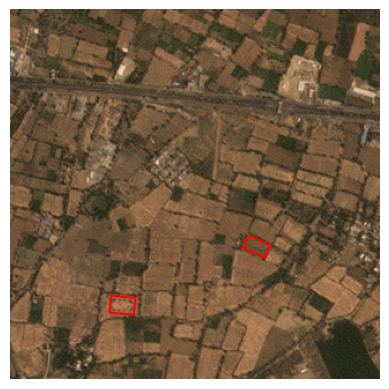

In [46]:
label_files = glob(join(save_dir, "labels", "*.txt"))
label_file = np.random.choice(label_files)
image_file = join(save_dir, "images", basename(splitext(label_file)[0] + ".tif"))

plt.figure()
image = Image.open(image_file)
print(image.size)
plt.imshow(image)
plt.axis("off")

labels = np.loadtxt(label_file, ndmin=2)
for label in labels:
    label[1:] = label[1:] * image_size
    plt.plot([label[1], label[3], label[5], label[7], label[1]], [label[2], label[4], label[6], label[8], label[2]], "r-")

In [ ]:
# Config
import os
import json
import geojson
import leafmap.leafmap as leafmap
import requests
from PIL import Image

# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Monitoring
from tqdm.notebook import tqdm

# IO
from os.path import join, exists, basename, dirname, splitext, expanduser
from glob import glob
from shapely.geometry import Point
from shapely import vectorized

import geopandas as gpd

# Parallel processing
from joblib import Parallel, delayed
import concurrent.futures as cf

import rioxarray as rxr

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
PLANET_API_KEY="PLAKea85382c048b4ba086c40e3823d83d11"
# PLANET_API_KEY = os.getenv("PLANET_API_KEY")
print(PLANET_API_KEY)
assert PLANET_API_KEY is not None
headers = {"Authorization": f"api-key {PLANET_API_KEY}"}
# # params = {
# #     "name__contains": quarter,
# # }

# response = requests.get(f"https://api.planet.com/basemaps/v1/mosaics", headers=headers)
# response.json()

PLAKea85382c048b4ba086c40e3823d83d11


In [ ]:
import numpy as np

In [ ]:
import os
import leafmap

# Set the Planet API key
PLANET_API_KEY = "PLAKea85382c048b4ba086c40e3823d83d11"
# Alternatively, retrieve the API key from environment variables:
# PLANET_API_KEY = os.getenv()

# Ensure the API key is set
assert PLANET_API_KEY is not None, "PLANET_API_KEY must be set!"
print(PLANET_API_KEY)

# Initialize the map
m = leafmap.Map()

# Add Planet imagery for the first quarter of 2024

m.add_planet_by_quarter(2024, 1, api_key=PLANET_API_KEY)

# Add geometry from the first row of the DataFrame
print(images_with_label.iloc[0:1][['geometry']].reset_index(drop=True))

# Get the geometry from the i-th row of images_with_label
i = np.random.randint(0, len(images_with_label))  
index_right = images_with_label.iloc[i]['index_right']

# Add the corresponding geometry from gdf_labels_webm to the map
m.add_gdf(gdf_labels_webm.iloc[index_right:index_right + 1].reset_index(drop=True), zoom_to_layer=True)

# Display the map
m


PLAKea85382c048b4ba086c40e3823d83d11
                                            geometry
0  POLYGON ((8412355.972 3336932.518, 8415413.454...


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# All states data marge into one file 


In [ ]:
bihar_label_path=f"../data/jcss_processed_data/bihar/labels"
#count the number of labels
label_files = glob(join(bihar_label_path, "*.txt"))
print(f"Number of labels: {len(label_files)}")
haryana_label_path=f"../data/jcss_processed_data/haryana/labels"
#count the number of labels
label_files = glob(join(haryana_label_path, "*.txt"))
print(f"Number of labels: {len(label_files)}")
uttar_pradesh_label_path=f"../data/jcss_processed_data/uttar_pradesh/labels"
#count the number of labels
label_files = glob(join(uttar_pradesh_label_path, "*.txt"))
print(f"Number of labels: {len(label_files)}")
punjab_label_path=f"../data/jcss_processed_data/punjab/labels"
#count the number of labels
label_files = glob(join(punjab_label_path, "*.txt"))
print(f"Number of labels: {len(label_files)}")
west_bengal_label_path=f"../data/jcss_processed_data/west_bengal/labels"
#count the number of labels
label_files = glob(join(west_bengal_label_path, "*.txt"))
print(f"Number of labels: {len(label_files)}")

# all_label_paths=glob("../data/jcss_processed_data/*/labels/*.txt")
# print(f"Total number of labels: {len(all_label_paths)}")


Number of labels: 3771
Number of labels: 1139
Number of labels: 10055
Number of labels: 1589
Number of labels: 1622
Total number of labels: 36352


In [ ]:
# make a new directory for the combined data
os.makedirs("../data/jcss_processed_data/combined_data/labels", exist_ok=True)

# copy the labels from each state to the combined data directory using python
for state in ["bihar", "haryana", "uttar_pradesh", "punjab", "west_bengal"]:
    label_files = glob(f"../data/jcss_processed_data/{state}/labels/*.txt")
    for label_file in label_files:
        os.system(f"cp {label_file} ../data/jcss_processed_data/combined_data/labels")



In [ ]:
import os
import glob

label_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/labels"

# List of patterns for source image directories
patterns = ["/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/processed_data/*/images", "/home/patel_zeel/kiln_compass_24/data/*/images"]

# Gather all image directories matching the patterns
image_dirs = []
for pattern in patterns:
    image_dirs.extend(glob.glob(pattern))

destination_image_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images"

# Create destination directory if it doesn't exist
os.makedirs(destination_image_dir, exist_ok=True)

# Iterate over all .txt files in the label directory
for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        # Extract the base filename (without extension)
        base_name = os.path.splitext(label_file)[0]
        # Construct the corresponding .tif filename
        tif_filename = f"{base_name}.tif"

        # Look for the .tif file in any of the source directories
        source_tif_path = None
        for image_dir in image_dirs:
            candidate_path = os.path.join(image_dir, tif_filename)
            if os.path.exists(candidate_path):
                source_tif_path = candidate_path
                break  # Stop searching once the file is found

        # If the file is found, create a symbolic link
        if source_tif_path:
            destination_tif_path = os.path.join(destination_image_dir, tif_filename)
            # Avoid overwriting existing symlinks
            if not os.path.exists(destination_tif_path):
                os.symlink(source_tif_path, destination_tif_path)
                print(f"Linked {source_tif_path} -> {destination_tif_path}")
            else:
                print(f"Symlink already exists for {destination_tif_path}")
        else:
            print(f"File not found: {tif_filename} in any of the source directories.")

print(f"All matching .tif files have been symlinked to {destination_image_dir}")


Linked /home/patel_zeel/kiln_compass_24/data/uttar_pradesh/images/9051063_3086524.tif -> /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images/9051063_3086524.tif
Linked /home/patel_zeel/kiln_compass_24/data/haryana/images/8556974_3412452.tif -> /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images/8556974_3412452.tif
Linked /home/patel_zeel/kiln_compass_24/data/uttar_pradesh/images/8885959_3281897.tif -> /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images/8885959_3281897.tif
Linked /home/patel_zeel/kiln_compass_24/data/bihar/images/9518858_2962391.tif -> /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images/9518858_2962391.tif
Linked /home/patel_zeel/kiln_compass_24/data/haryana/images/8584492_3544535.tif -> /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/data/combined_data/images/8584492_3544535.tif
Linked /home/patel_zeel/kiln_compass_24/data/uttar_prad